In [4]:
air_quality_df = pd.read_csv('rwanda_air_quality_2020_2025.csv')

In [7]:
air_quality_df.head()

Dist_ID    District    Name  Prov_ID     Province  Sect_ID  NO2_mean  year  \
0       11  Nyarugenge  Gitega        1  Kigali City     1101  0.000041  2020   
1       11  Nyarugenge  Gitega        1  Kigali City     1101  0.000039  2020   
2       11  Nyarugenge  Gitega        1  Kigali City     1101  0.000038  2020   
3       11  Nyarugenge  Gitega        1  Kigali City     1101  0.000038  2020   
4       11  Nyarugenge  Gitega        1  Kigali City     1101  0.000043  2020   

   month     date   CO_mean      SO2_mean   O3_mean  AER_mean  CH4_mean  
0      1  2020-01  0.038910 -4.553785e-05  0.111056 -1.252367       NaN  
1      2  2020-02  0.034758 -6.027024e-07  0.113404 -1.377423       NaN  
2      3  2020-03  0.035565  1.019581e-05  0.116727 -1.524711       NaN  
3      4  2020-04  0.031162  3.465083e-04  0.116457 -1.392731       NaN  
4      5  2020-05  0.027599  4.715642e-05  0.114809 -1.535792       NaN

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
import matplotlib.ticker as mtick
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import contextily as ctx

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Custom color palette
colors = ["#2C3E50", "#E74C3C", "#3498DB", "#27AE60", "#F39C12", "#8E44AD"]
sns.set_palette(colors)

# Load data
df = pd.read_csv('rwanda_air_quality_2020_2025.csv')

# Load Rwanda sectors shapefile
sectors_gdf = gpd.read_file('rwa_sector/Sector.shp')

# Merge with sectors GeoDataFrame
df_with_geo = sectors_gdf.merge(df, left_on='Sect_ID', right_on='Sect_ID')

# Fill NaN values with 0 for visualization purposes
df = df.fillna(0)
df_with_geo = df_with_geo.fillna(0)

# Basic info about the dataset
print(f"Total rows: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of sectors: {df['Sect_ID'].nunique()}")
print(f"Number of months: {df['date'].nunique()}")

# Show column names and first few rows
print("\nColumns:", df_with_geo.columns.tolist())
print("\nSample data:")
display(df_with_geo.head())

Total rows: 25376
Date range: 2020-01 to 2025-01
Number of sectors: 416
Number of months: 61

Columns: ['Prov_ID_x', 'Province_x', 'Dist_ID_x', 'District_x', 'Sect_ID', 'Name_x', 'geometry', 'Dist_ID_y', 'District_y', 'Name_y', 'Prov_ID_y', 'Province_y', 'NO2_mean', 'year', 'month', 'date', 'CO_mean', 'SO2_mean', 'O3_mean', 'AER_mean', 'CH4_mean']

Sample data:


Prov_ID_x   Province_x  Dist_ID_x  District_x  Sect_ID  Name_x  \
0        1.0  Kigali City       11.0  Nyarugenge   1101.0  Gitega   
1        1.0  Kigali City       11.0  Nyarugenge   1101.0  Gitega   
2        1.0  Kigali City       11.0  Nyarugenge   1101.0  Gitega   
3        1.0  Kigali City       11.0  Nyarugenge   1101.0  Gitega   
4        1.0  Kigali City       11.0  Nyarugenge   1101.0  Gitega   

                                            geometry  Dist_ID_y  District_y  \
0  POLYGON ((505371.714 4785311.96, 505376.955 47...         11  Nyarugenge   
1  POLYGON ((505371.714 4785311.96, 505376.955 47...         11  Nyarugenge   
2  POLYGON ((505371.714 4785311.96, 505376.955 47...         11  Nyarugenge   
3  POLYGON ((505371.714 4785311.96, 505376.955 47...         11  Nyarugenge   
4  POLYGON ((505371.714 4785311.96, 505376.955 47...         11  Nyarugenge   

   Name_y  ...   Province_y  NO2_mean  year  month     date   CO_mean  \
0  Gitega  ...  Kigali City  0.000041  2020      1  2020-01  0.038910   
1  Gitega  ...  Kigali City  0.000039  2020      2  2020-02  0.034758   
2  Gitega  ...  Kigali City  0.000038  2020      3  2020-03  0.035565   
3  Gitega  ...  Kigali City  0.000038  2020      4  2020-04  0.031162   
4  Gitega  ...  Kigali City  0.000043  2020      5  2020-05  0.027599   

       SO2_mean   O3_mean  AER_mean  CH4_mean  
0 -4.553785e-05  0.111056 -1.252367       0.0  
1 -6.027024e-07  0.113404 -1.377423       0.0  
2  1.019581e-05  0.116727 -1.524711       0.0  
3  3.465083e-04  0.116457 -1.392731       0.0  
4  4.715642e-05  0.114809 -1.535792       0.0  

[5 rows x 21 columns]

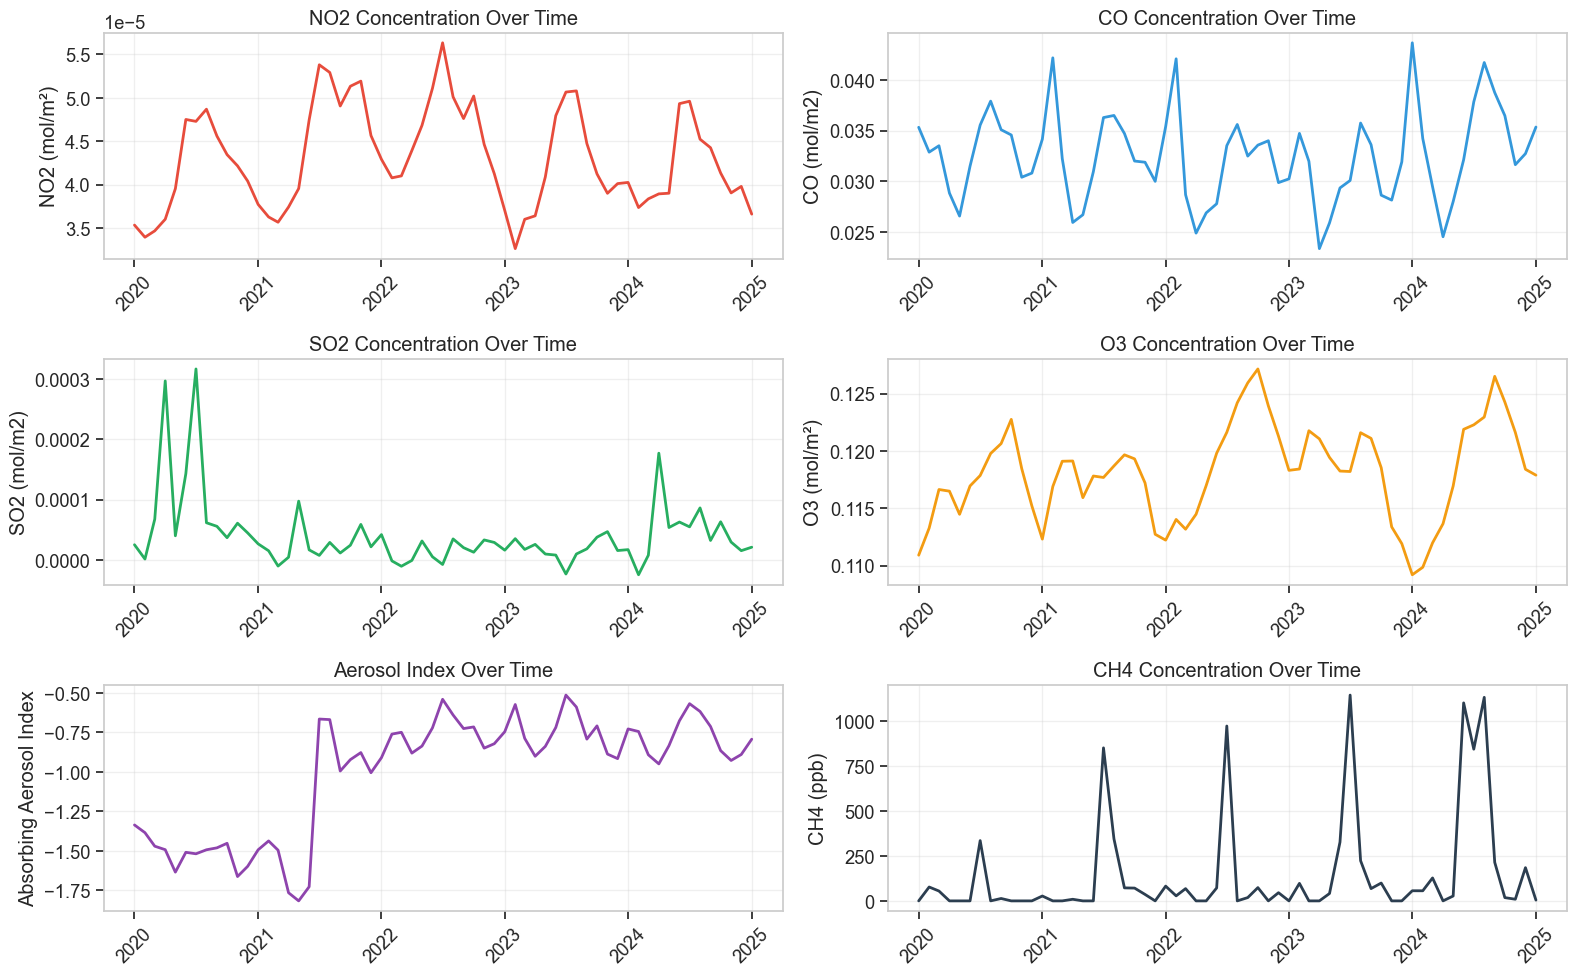

In [15]:
# Prepare monthly averages
monthly_avg = df.groupby('date').agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean',
    'CH4_mean': 'mean'
}).reset_index()

# Convert date to datetime
monthly_avg['date'] = pd.to_datetime(monthly_avg['date'])
monthly_avg = monthly_avg.sort_values('date')

# Plot time series for each pollutant
plt.figure(figsize=(16, 10))

# NO2
plt.subplot(3, 2, 1)
plt.plot(monthly_avg['date'], monthly_avg['NO2_mean'], color='#E74C3C', linewidth=2)
plt.title('NO2 Concentration Over Time')
plt.ylabel('NO2 (mol/m²)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# CO
plt.subplot(3, 2, 2)
plt.plot(monthly_avg['date'], monthly_avg['CO_mean'], color='#3498DB', linewidth=2)
plt.title('CO Concentration Over Time')
plt.ylabel('CO (mol/m2)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# SO2
plt.subplot(3, 2, 3)
plt.plot(monthly_avg['date'], monthly_avg['SO2_mean'], color='#27AE60', linewidth=2)
plt.title('SO2 Concentration Over Time')
plt.ylabel('SO2 (mol/m2)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# O3
plt.subplot(3, 2, 4)
plt.plot(monthly_avg['date'], monthly_avg['O3_mean'], color='#F39C12', linewidth=2)
plt.title('O3 Concentration Over Time')
plt.ylabel('O3 (mol/m²)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# AER
plt.subplot(3, 2, 5)
plt.plot(monthly_avg['date'], monthly_avg['AER_mean'], color='#8E44AD', linewidth=2)
plt.title('Aerosol Index Over Time')
plt.ylabel('Absorbing Aerosol Index')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# CH4
plt.subplot(3, 2, 6)
plt.plot(monthly_avg['date'], monthly_avg['CH4_mean'], color='#2C3E50', linewidth=2)
plt.title('CH4 Concentration Over Time')
plt.ylabel('CH4 (ppb)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('air_quality_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

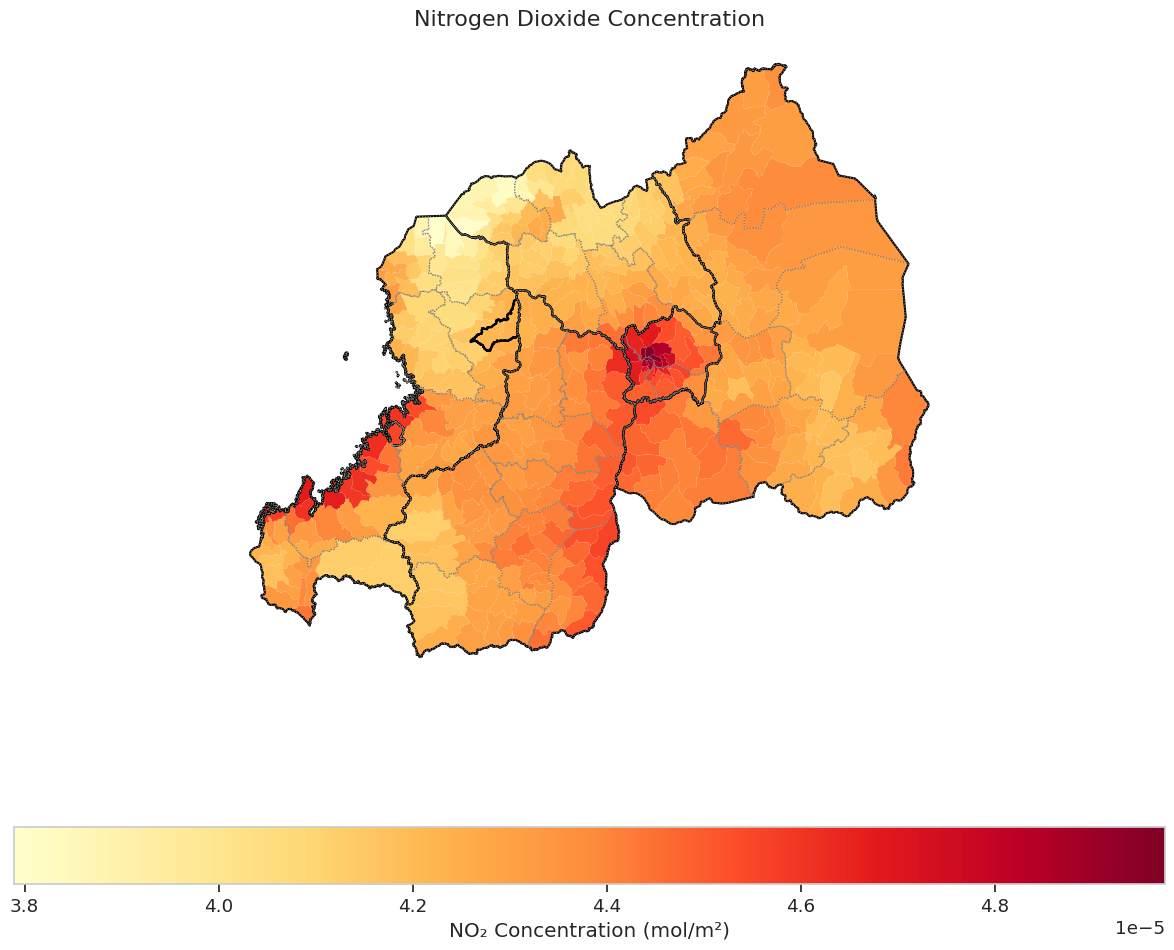

<Figure size 640x480 with 0 Axes>

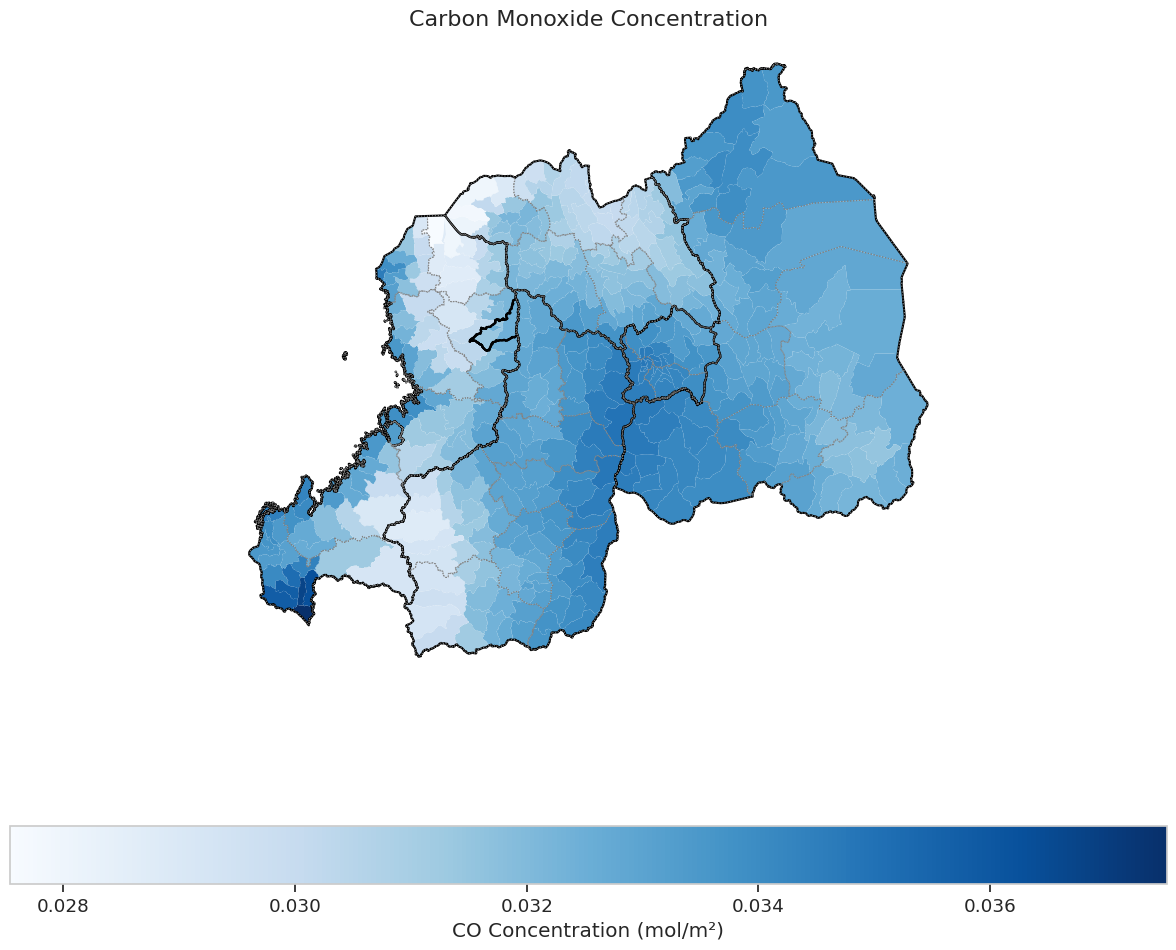

<Figure size 640x480 with 0 Axes>

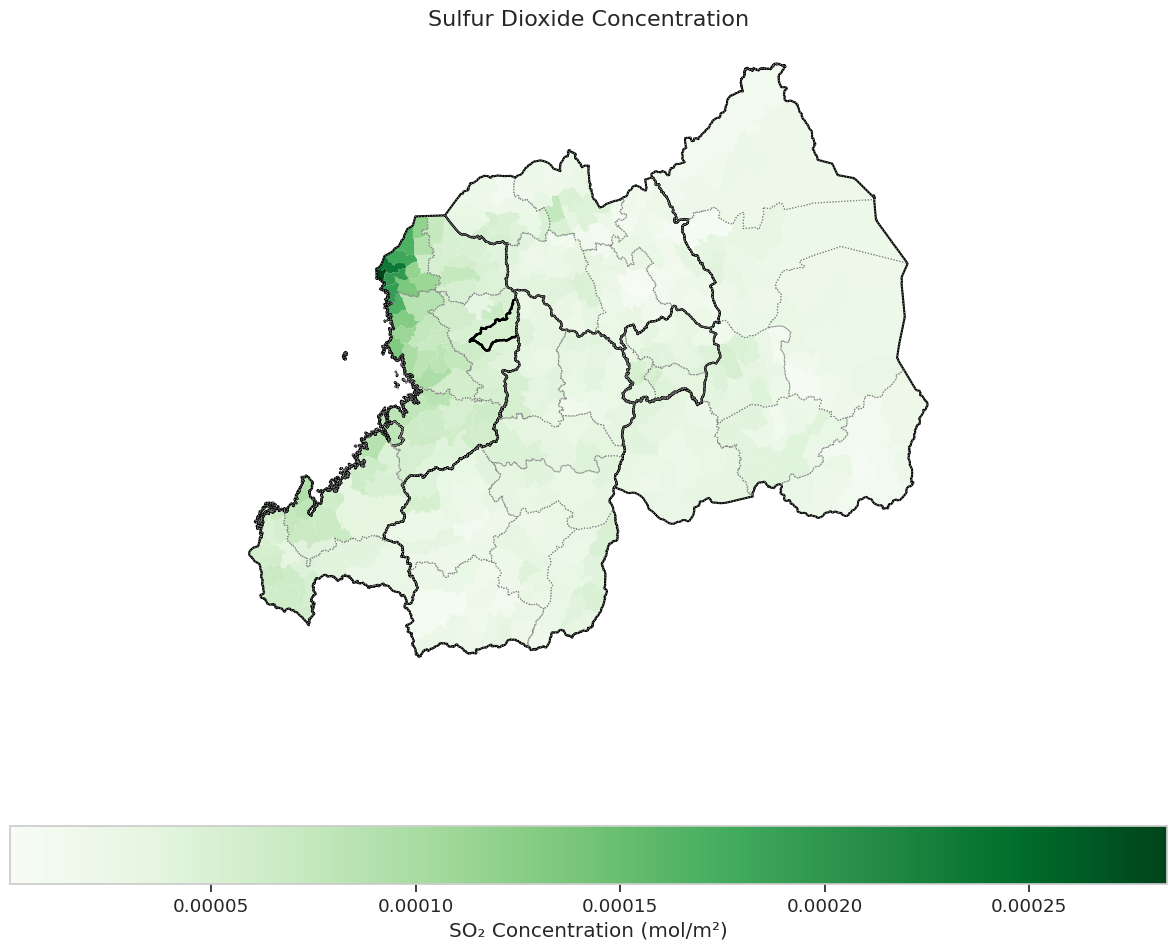

<Figure size 640x480 with 0 Axes>

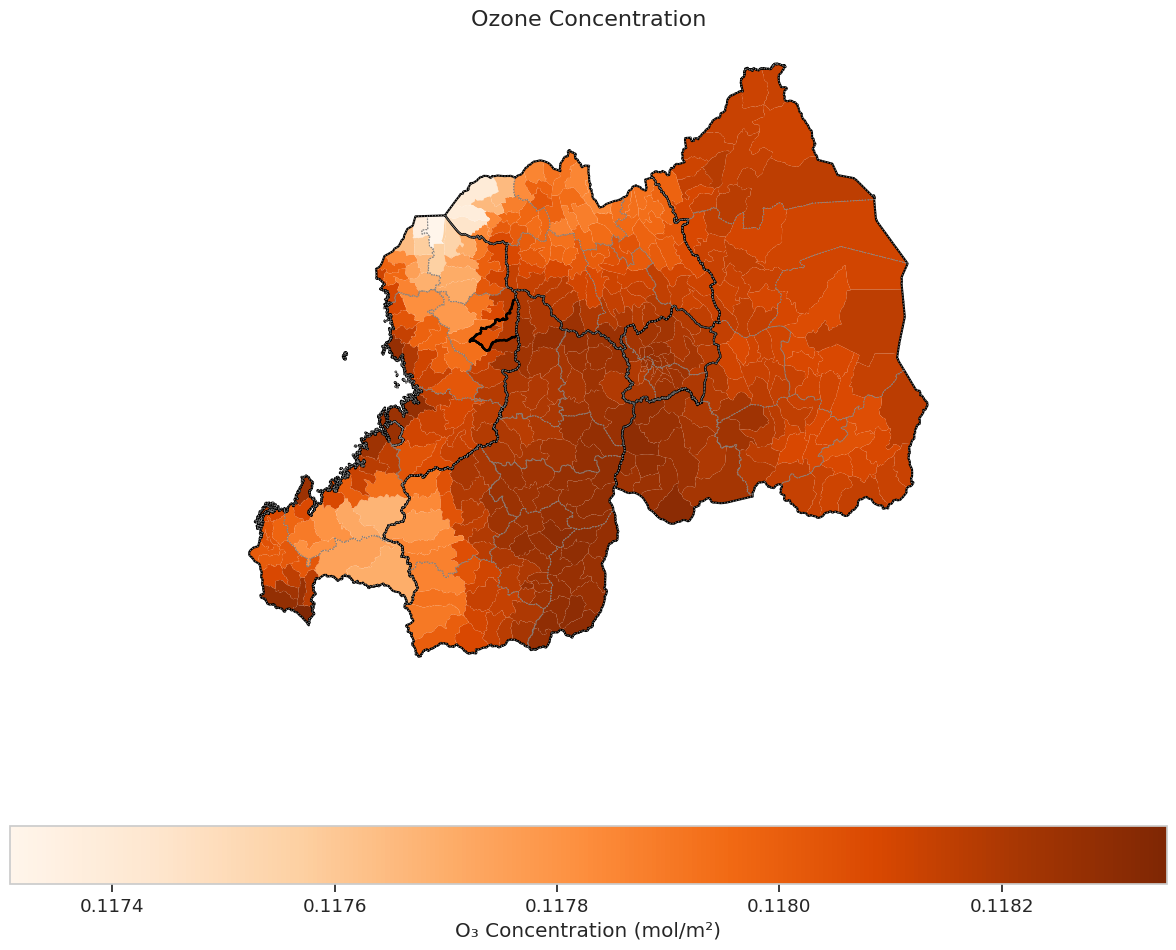

<Figure size 640x480 with 0 Axes>

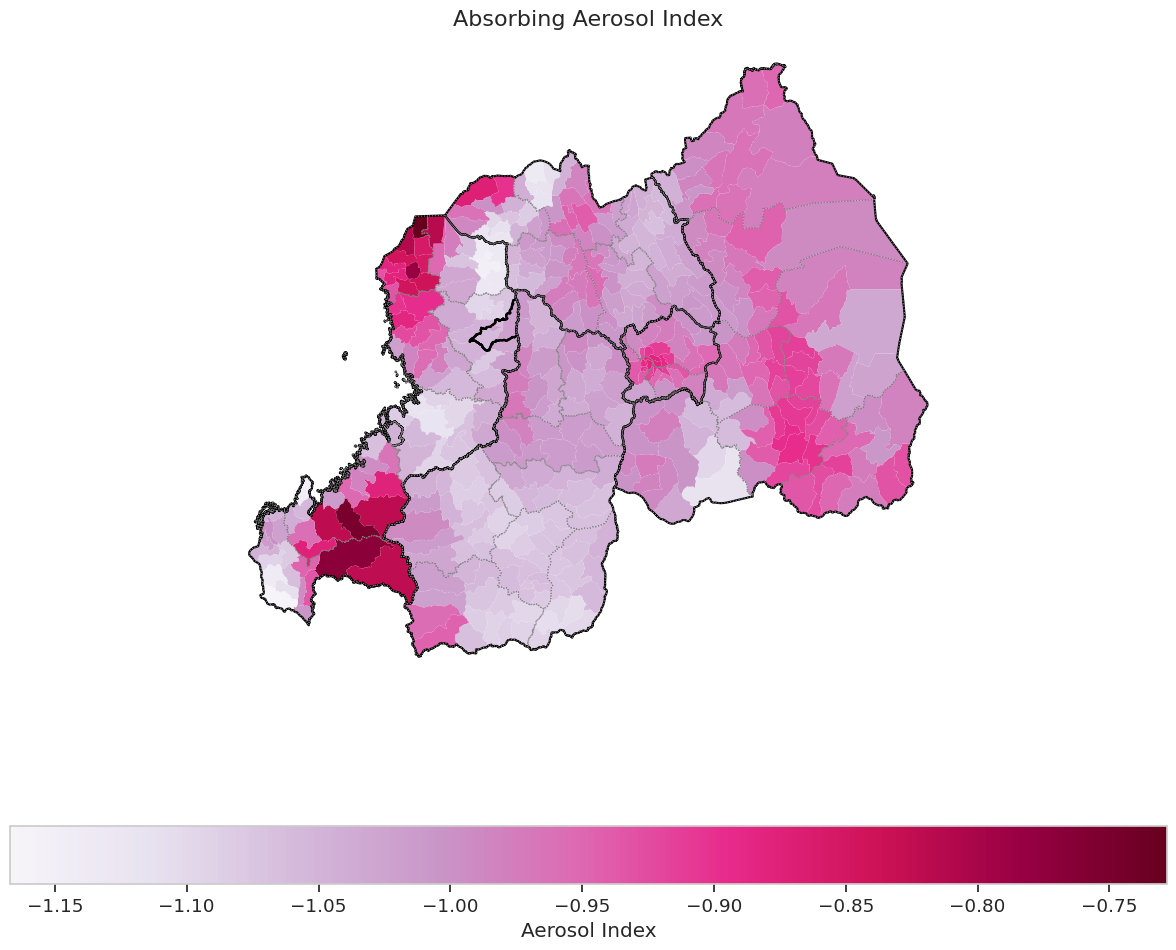

<Figure size 640x480 with 0 Axes>

In [23]:
# 3. Spatial Analysis: Pollutant Distribution Maps

# Calculate average pollutant levels by sector
import matplotlib.font_manager as fm
sector_avg = df.groupby('Sect_ID').agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean',
    'CH4_mean': 'mean',
    'District': 'first',
    'Province': 'first'
}).reset_index()


sector_avg_gdf = sectors_gdf.merge(sector_avg, on='Sect_ID')

# Use a font that supports subscripts
plt.rcParams['font.family'] = 'DejaVu Sans'

# Define a function to create maps


def create_pollutant_map(gdf, column, title, label, cmap='viridis'):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot with proper colormap
    gdf.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        legend=True,
        legend_kwds={'label': label, 'orientation': "horizontal"}
    )

    # Add province boundaries with bold lines
    province_boundaries = gdf.dissolve(by='Province_x')
    province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)

    # Add district boundaries with thinner lines
    district_boundaries = gdf.dissolve(by='District_x')
    district_boundaries.boundary.plot(
        ax=ax, color='gray', linewidth=0.8, linestyle=':')

    # Add title and labels
    plt.title(title, fontsize=16)
    plt.axis('off')

    # Display the figure before saving
    plt.tight_layout()
    plt.show()

    # Save the figure
    plt.savefig(f'{column}_map.png', dpi=300, bbox_inches='tight')

    return fig, ax


# Create maps for each pollutant
pollutants = [
    ('NO2_mean', 'Nitrogen Dioxide Concentration',
     'NO₂ Concentration (mol/m²)', 'YlOrRd'),
    ('CO_mean', 'Carbon Monoxide Concentration',
     'CO Concentration (mol/m²)', 'Blues'),
    ('SO2_mean', 'Sulfur Dioxide Concentration',
     'SO₂ Concentration (mol/m²)', 'Greens'),
    ('O3_mean', 'Ozone Concentration', 'O₃ Concentration (mol/m²)', 'Oranges'),
    ('AER_mean', 'Absorbing Aerosol Index', 'Aerosol Index', 'PuRd')
]

for col, title, label, cmap in pollutants:
    create_pollutant_map(sector_avg_gdf, col, title, label, cmap)

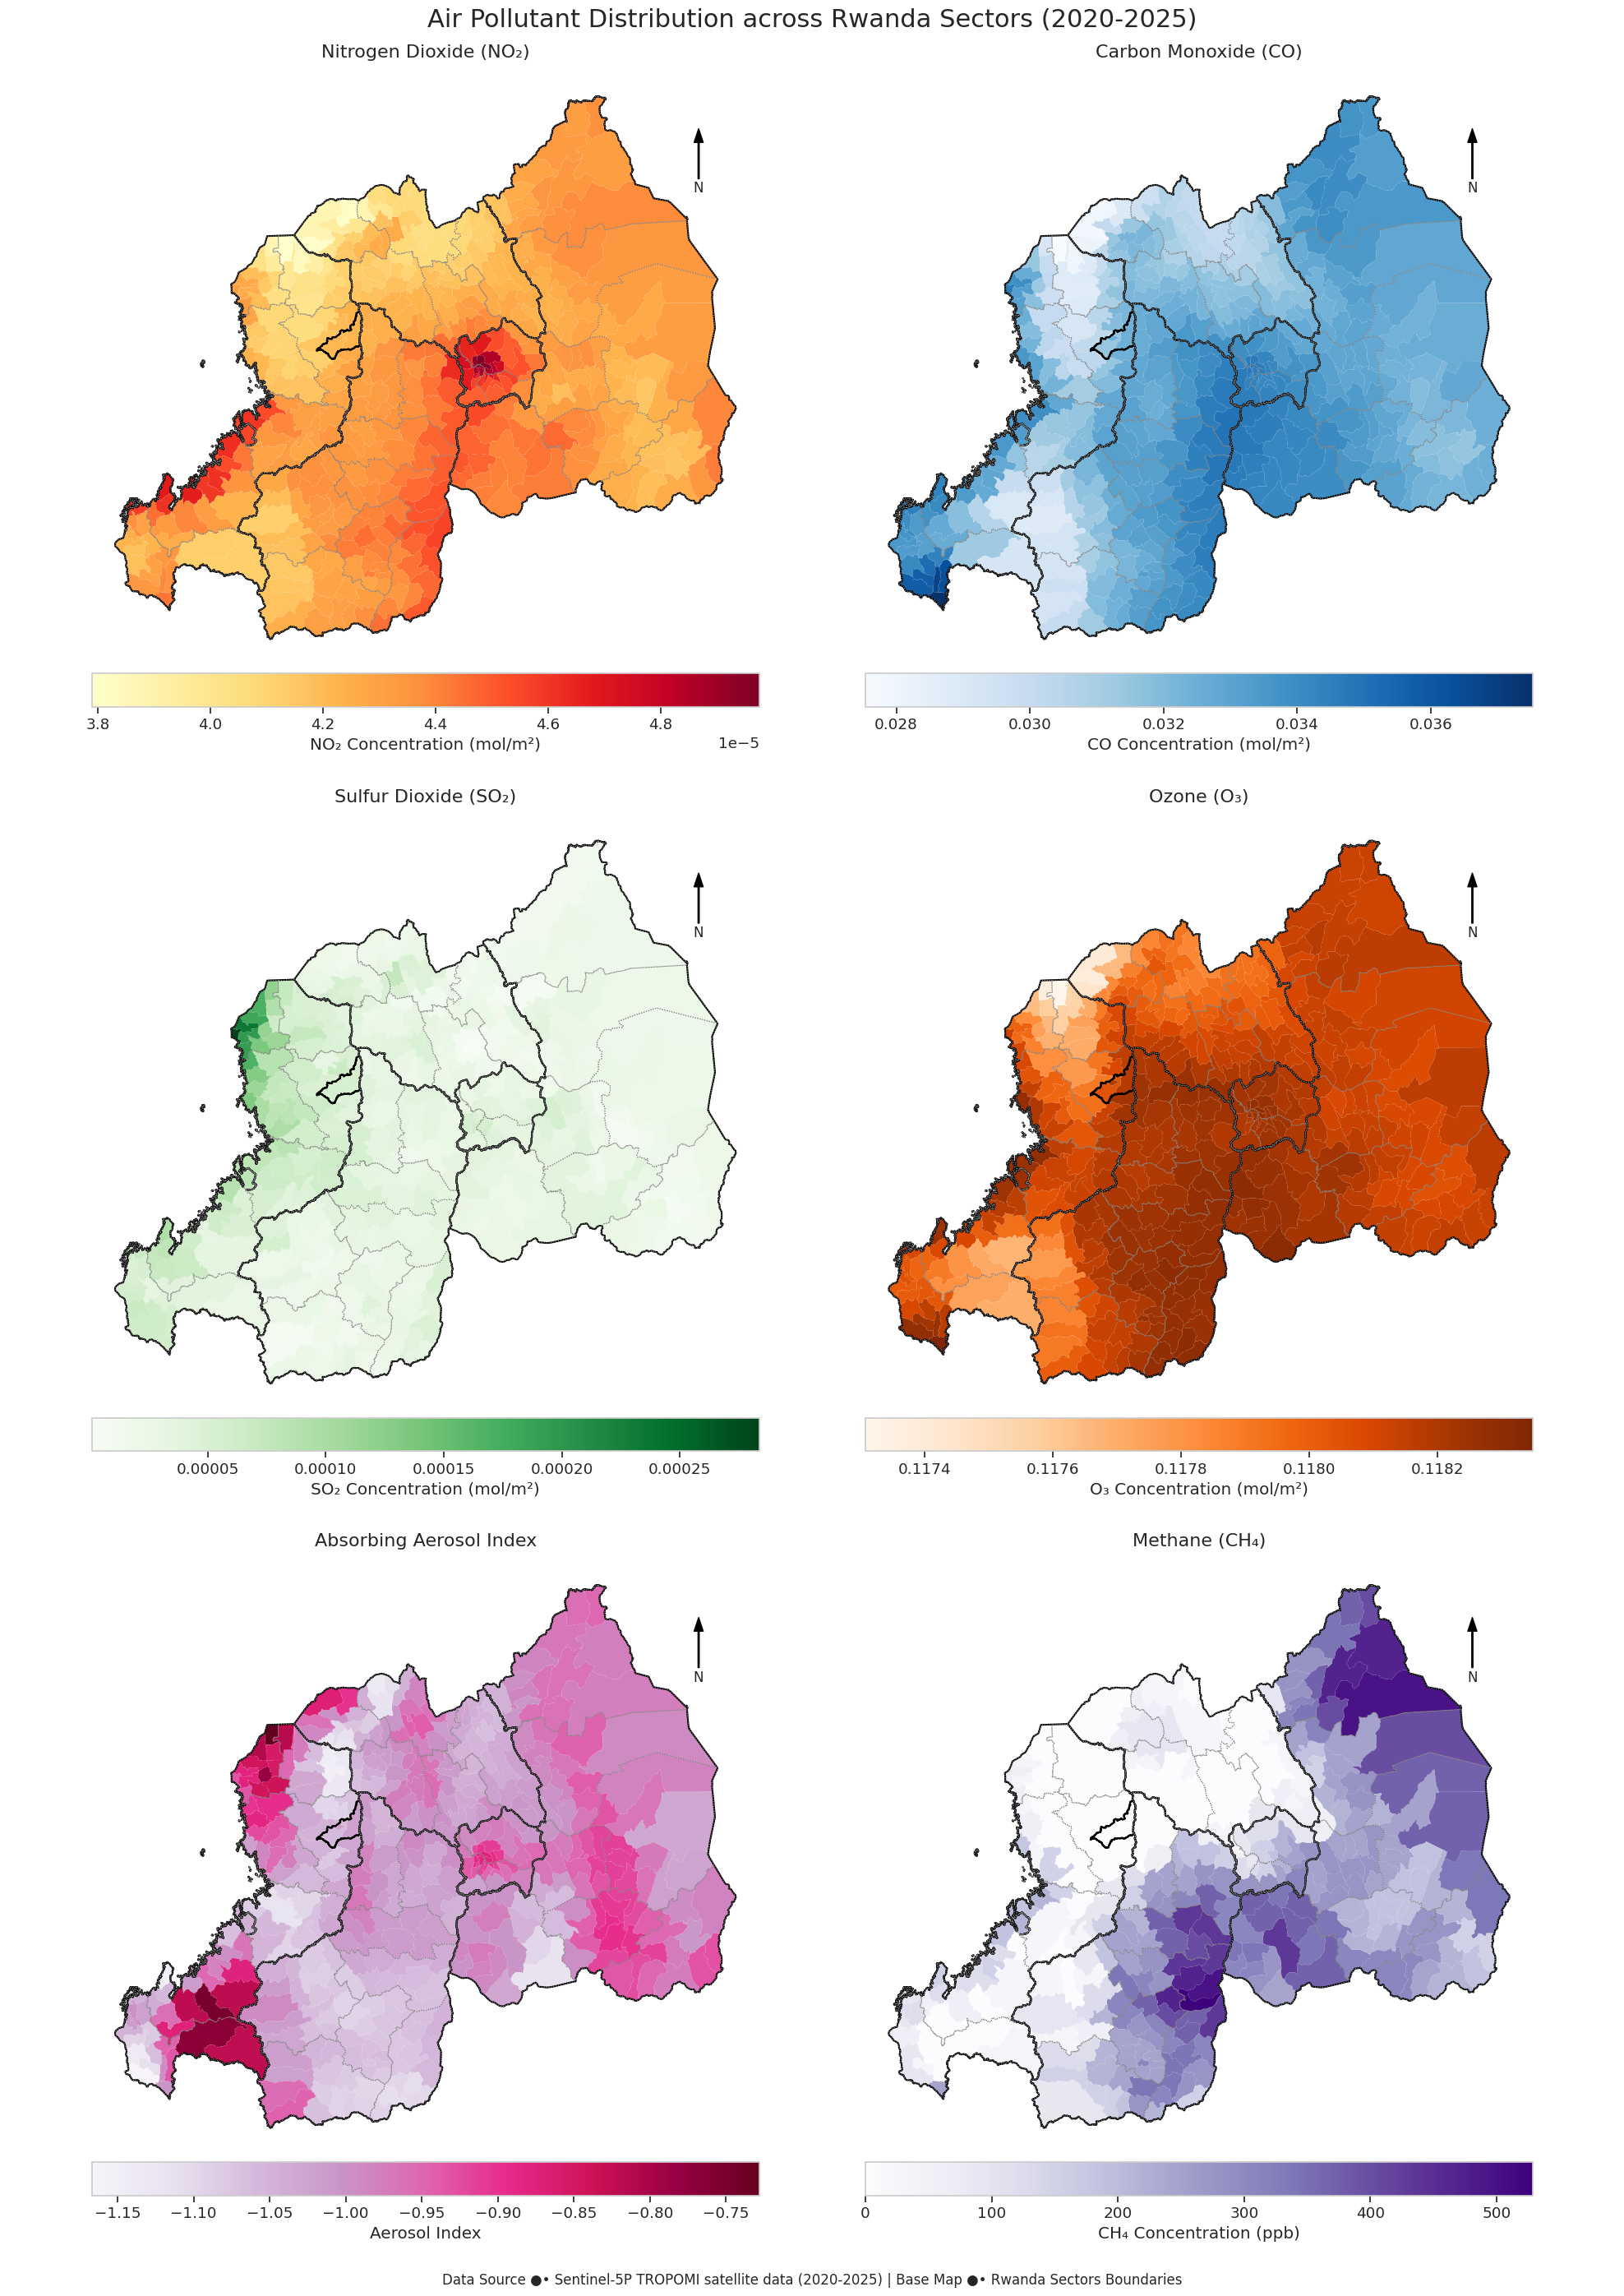

<Figure size 640x480 with 0 Axes>

In [ ]:
# 3. Spatial Analysis: Pollutant Distribution Maps in a Single Figure

import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Calculate average pollutant levels by sector
sector_avg = df.groupby('Sect_ID').agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean',
    'CH4_mean': 'mean',
    'District': 'first',
    'Province': 'first'
}).reset_index()

# Merge with GeoDataFrame
sector_avg_gdf = sectors_gdf.merge(sector_avg, on='Sect_ID')

# Use a font that supports subscripts
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create a single figure with all pollutant maps
fig = plt.figure(figsize=(20, 28))
fig.suptitle('Air Pollutant Distribution across Rwanda Sectors (2020-2025)', fontsize=22, y=0.99)

# plt.subplots_adjust(bottom=0.85)
# Add a footnote with data source
fig.text(0.5, 0.001,'Data Source ●• Sentinel-5P TROPOMI satellite data (2020-2025) | Base Map ●• Rwanda Sectors Boundaries', ha='center', fontsize=12)

# # Create grid for subplots
# gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[
#                        1, 1, 0.1], figure=fig)

# Pollutant definitions
pollutants = [
    ('NO2_mean', 'Nitrogen Dioxide (NO₂)', 'NO₂ Concentration (mol/m²)', 'YlOrRd'),
    ('CO_mean', 'Carbon Monoxide (CO)', 'CO Concentration (mol/m²)', 'Blues'),
    ('SO2_mean', 'Sulfur Dioxide (SO₂)', 'SO₂ Concentration (mol/m²)', 'Greens'),
    ('O3_mean', 'Ozone (O₃)', 'O₃ Concentration (mol/m²)', 'Oranges'),
    ('AER_mean', 'Absorbing Aerosol Index', 'Aerosol Index', 'PuRd'),
    ('CH4_mean', 'Methane (CH₄)', 'CH₄ Concentration (ppb)', 'Purples')
]
# create grid for the 6 subplots

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], figure=fig)

# Plot each pollutant
for i, (col, title, label, cmap) in enumerate(pollutants):
    # Create subplot
    ax = fig.add_subplot(gs[i//2, i % 2])

    # Plot with proper colormap
    sector_avg_gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        legend_kwds={'label': label, 'orientation': "horizontal",
                     'shrink': 0.8, 'aspect': 20, 'pad': 0.01}
    )

    # Add province boundaries with bold lines
    try:
        province_boundaries = sector_avg_gdf.dissolve(by='Province_x')
        province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)
    except:
        province_boundaries = sector_avg_gdf.dissolve(by='Province')
        province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)

    # Add district boundaries with thinner lines
    try:
        district_boundaries = sector_avg_gdf.dissolve(by='District_x')
        district_boundaries.boundary.plot(
            ax=ax, color='gray', linewidth=0.8, linestyle=':')
    except:
        district_boundaries = sector_avg_gdf.dissolve(by='District')
        district_boundaries.boundary.plot(
            ax=ax, color='gray', linewidth=0.8, linestyle=':')

    # Add title and format
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_axis_off()

    # Add North arrow
    arrow_x, arrow_y = 0.9, 0.9
    ax.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-0.1),
                arrowprops=dict(facecolor='black', width=1, headwidth=8),
                ha='center', va='center', fontsize=12,
                xycoords=ax.transAxes)
    
# Add a shared legend for boundaries at the bottom
ax_legend = fig.add_subplot(gs[2, :])
ax_legend.axis('off')

# # Create custom legend elements
# legend_elements = [
#     Line2D([0], [0], color='black', linewidth=1.5, label='Province Boundary'),
#     Line2D([0], [0], color='gray', linewidth=0.8,
#            linestyle=':', label='District Boundary'),
#     Patch(facecolor='#E74C3C', edgecolor='black',
#           label='High Concentration Area'),
#     Patch(facecolor='#F9E79F', edgecolor='black',
#           label='Medium Concentration Area'),
#     Patch(facecolor='#D5F5E3', edgecolor='black',
#           label='Low Concentration Area')
# ]

# # Add the legend
# ax_legend.legend(handles=legend_elements, loc='center', ncol=5, frameon=True,
#                  fancybox=True, shadow=True, fontsize=12)

# # Add findings text
# findings_text = """Key Findings:
# 1. Higher NO₂ levels appear in urban centers like Kigali, indicating traffic and industrial pollution.
# 2. CO concentrations follow similar patterns but with wider regional spread.
# 3. SO₂ and O₃ show more complex distribution patterns influenced by both urban activities and natural factors.
# 4. The Aerosol Index reveals areas affected by particulate matter, often from biomass burning and dust.
# """

# ax_legend.text(0.5, -0.2, findings_text, transform=ax_legend.transAxes,
#                ha='center', va='center', fontsize=12,
#                bbox=dict(boxstyle='round,pad=0.5', facecolor='whitesmoke', alpha=0.8))

plt.tight_layout()

# Show the figure
plt.show()

# Save high-quality figure
plt.savefig('rwanda_pollutants_distribution_map.png', dpi=300)

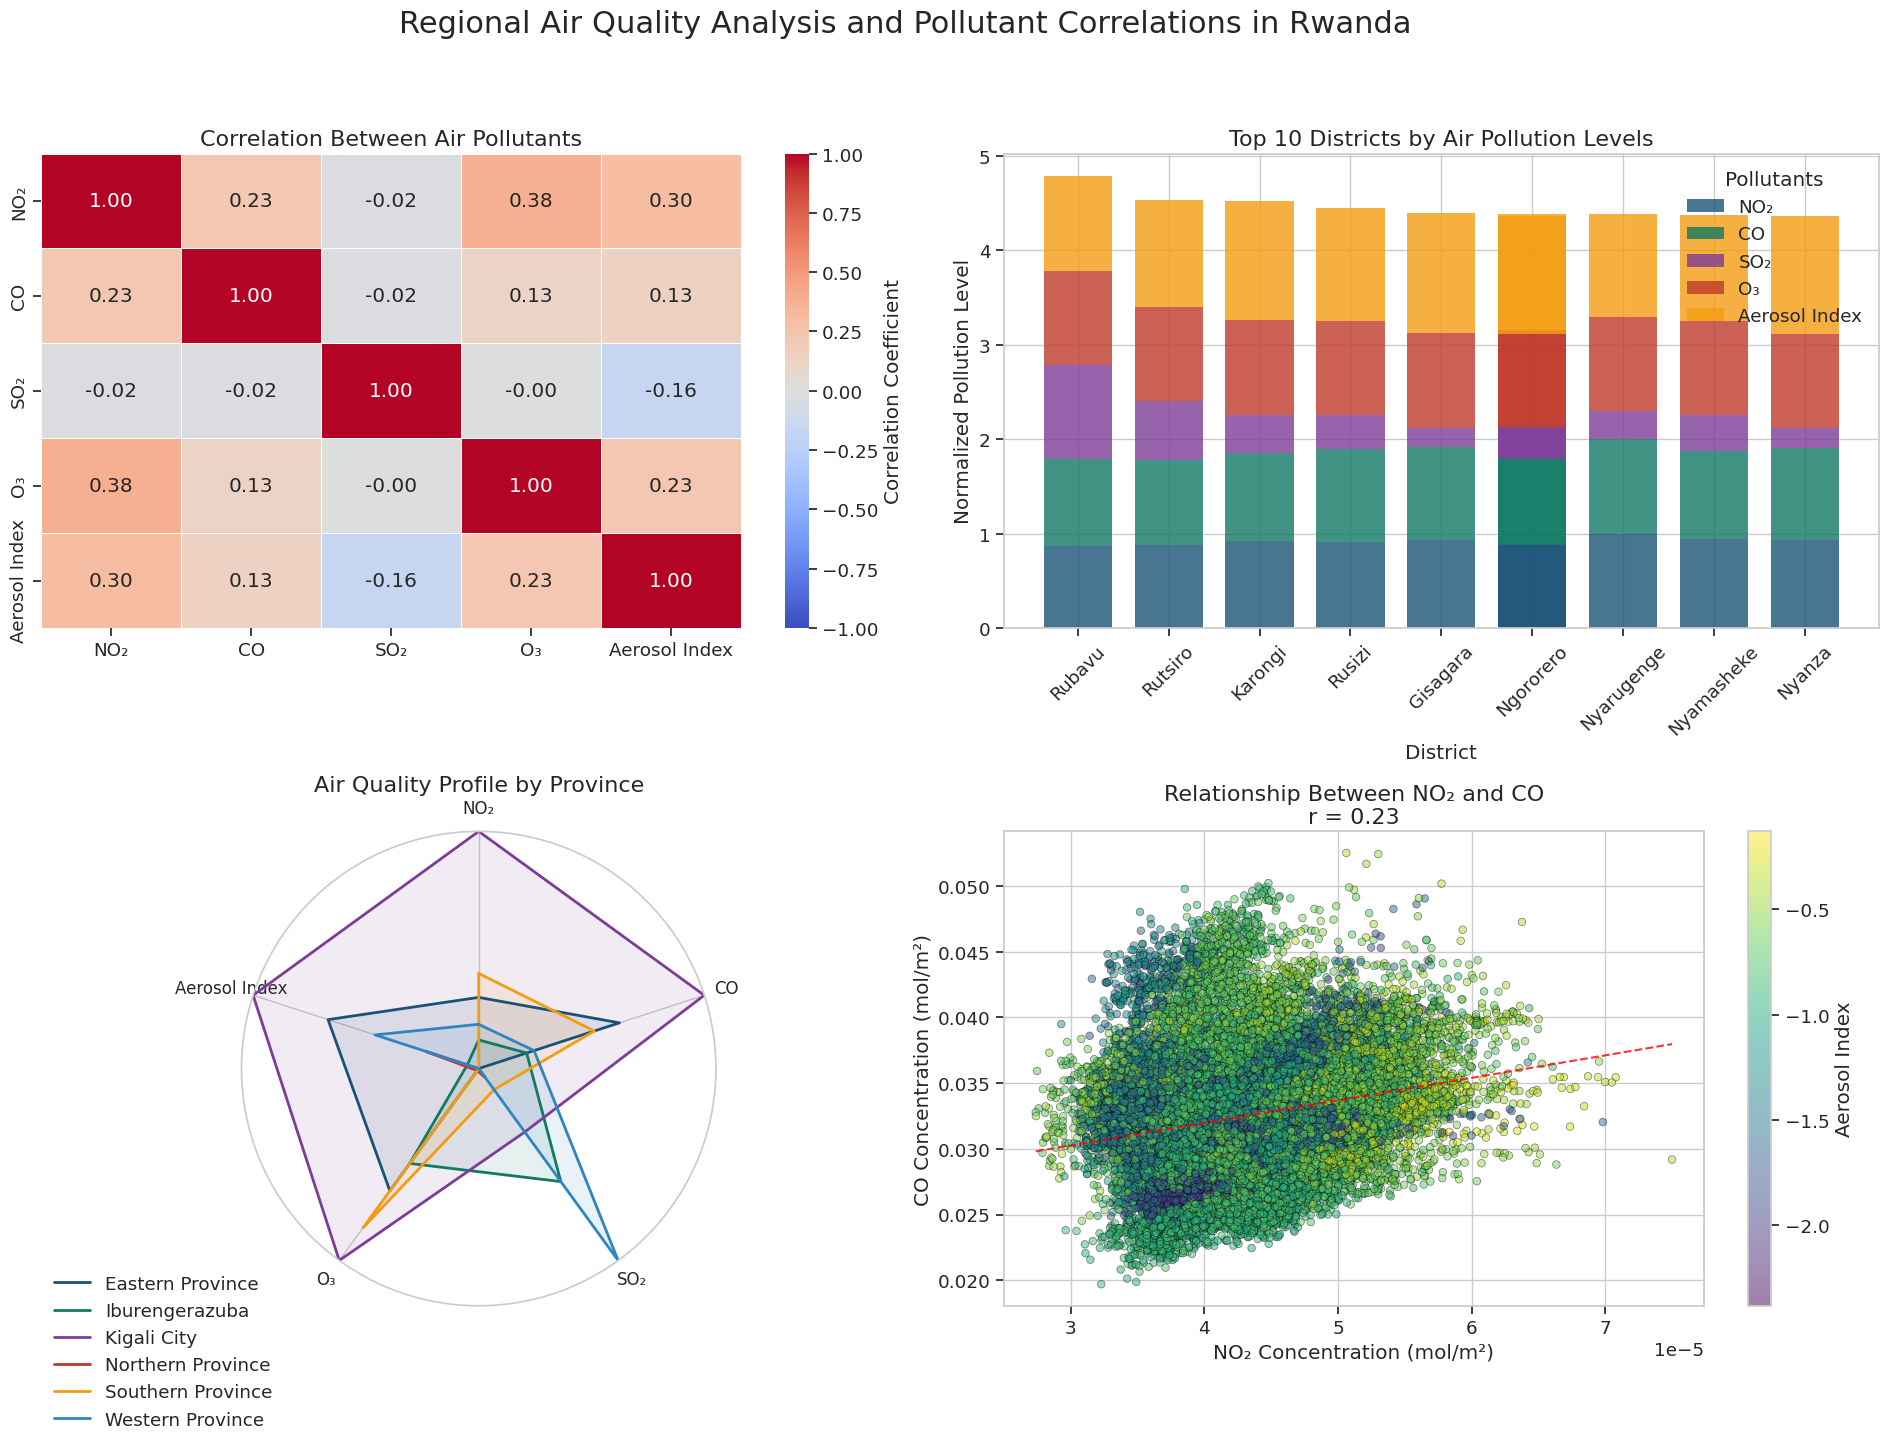

In [43]:
# 5. Regional Analysis and Pollutant Correlations

# Set the visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_context("notebook", font_scale=1.2)
colors = ["#1A5276", "#117A65", "#7D3C98", "#C0392B", "#F39C12", "#2E86C1"]

# Calculate district-level averages
district_avg = df.groupby(['District', 'Province']).agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean'
}).reset_index()

# Create a comprehensive regional analysis figure
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Regional Air Quality Analysis and Pollutant Correlations in Rwanda',
             fontsize=22, y=0.98)

# 1. Correlation Heatmap
ax1 = plt.subplot2grid((2, 2), (0, 0))
pollutant_cols = ['NO2_mean', 'CO_mean', 'SO2_mean', 'O3_mean', 'AER_mean']
pollutant_labels = ['NO₂', 'CO', 'SO₂', 'O₃', 'Aerosol Index']

# Calculate correlation matrix
corr_matrix = df[pollutant_cols].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            xticklabels=pollutant_labels, yticklabels=pollutant_labels,
            linewidths=0.5, ax=ax1, vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
ax1.set_title('Correlation Between Air Pollutants', fontsize=16)

# 2. Top Districts by Pollutant Levels
ax2 = plt.subplot2grid((2, 2), (0, 1))

# Calculate a composite air quality index for ranking
district_avg['AQI_proxy'] = (
    district_avg['NO2_mean'] / district_avg['NO2_mean'].max() +
    district_avg['CO_mean'] / district_avg['CO_mean'].max() +
    district_avg['SO2_mean'] / district_avg['SO2_mean'].max() +
    district_avg['O3_mean'] / district_avg['O3_mean'].max() +
    district_avg['AER_mean'] / district_avg['AER_mean'].max()
) / 5  # Average of normalized values

# Sort and get top 10 districts with highest composite pollution
top_districts = district_avg.sort_values('AQI_proxy', ascending=False).head(10)

# Create stacked bar chart
bar_width = 0.75
bottom = np.zeros(len(top_districts))

for i, (col, label, color) in enumerate(zip(
    pollutant_cols,
    pollutant_labels,
    colors[:5]
)):
    # Normalize each pollutant for fair comparison
    normalized = top_districts[col] / top_districts[col].max()

    ax2.bar(top_districts['District'], normalized, bar_width,
            bottom=bottom, label=label, color=color, alpha=0.8)
    bottom += normalized

ax2.set_title('Top 10 Districts by Air Pollution Levels', fontsize=16)
ax2.set_ylabel('Normalized Pollution Level')
ax2.set_xlabel('District')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Pollutants')

# 3. Provincial Comparison - Fixed with proper polar projection
ax3 = plt.subplot2grid((2, 2), (1, 0), projection='polar')

# Calculate province-level averages
province_avg = df.groupby('Province').agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean'
}).reset_index()

# Normalize data for radar chart
for col in pollutant_cols:
    province_avg[f'{col}_norm'] = ((province_avg[col] - province_avg[col].min()) /
                                   (province_avg[col].max() - province_avg[col].min()))

# Set up radar chart
categories = pollutant_labels
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Initialize the radar plot
ax3.set_theta_offset(np.pi / 2)
ax3.set_theta_direction(-1)
ax3.set_rlabel_position(0)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories, size=12)
ax3.set_ylim(0, 1)
ax3.set_yticks([])  # Don't show radial ticks

# Plot each province
for i, row in province_avg.iterrows():
    values = [row[f'{col}_norm'] for col in pollutant_cols]
    values += values[:1]  # Close the loop

    ax3.plot(angles, values, linewidth=2, linestyle='solid',
             label=row['Province'], color=colors[i % len(colors)])
    ax3.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])

ax3.set_title('Air Quality Profile by Province', fontsize=16)
ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 4. Bivariate Analysis
ax4 = plt.subplot2grid((2, 2), (1, 1))

# Create scatter plot matrix for key pollutant relationships
# Focus on NO2 vs. CO, which are both related to combustion
scatter = ax4.scatter(
    df['NO2_mean'],
    df['CO_mean'],
    c=df['AER_mean'],  # Color by aerosol index
    cmap='viridis',
    alpha=0.5,
    s=30,
    edgecolor='k',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Aerosol Index')

# Add trend line
z = np.polyfit(df['NO2_mean'], df['CO_mean'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['NO2_mean'].min(), df['NO2_mean'].max(), 100)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8)

# Calculate correlation coefficient
corr_coef = np.corrcoef(df['NO2_mean'], df['CO_mean'])[0, 1]

ax4.set_xlabel('NO₂ Concentration (mol/m²)')
ax4.set_ylabel('CO Concentration (mol/m²)')
ax4.set_title(
    f'Relationship Between NO₂ and CO\nr = {corr_coef:.2f}', fontsize=16)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('rwanda_regional_pollutant_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_7584\12787397.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_no2 = df_with_urban.groupby(['urbanization', 'season'])[
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_7584\12787397.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_o3 = df_with_urban.groupby(['urbanization', 'season'])[
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_7584\12787397.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

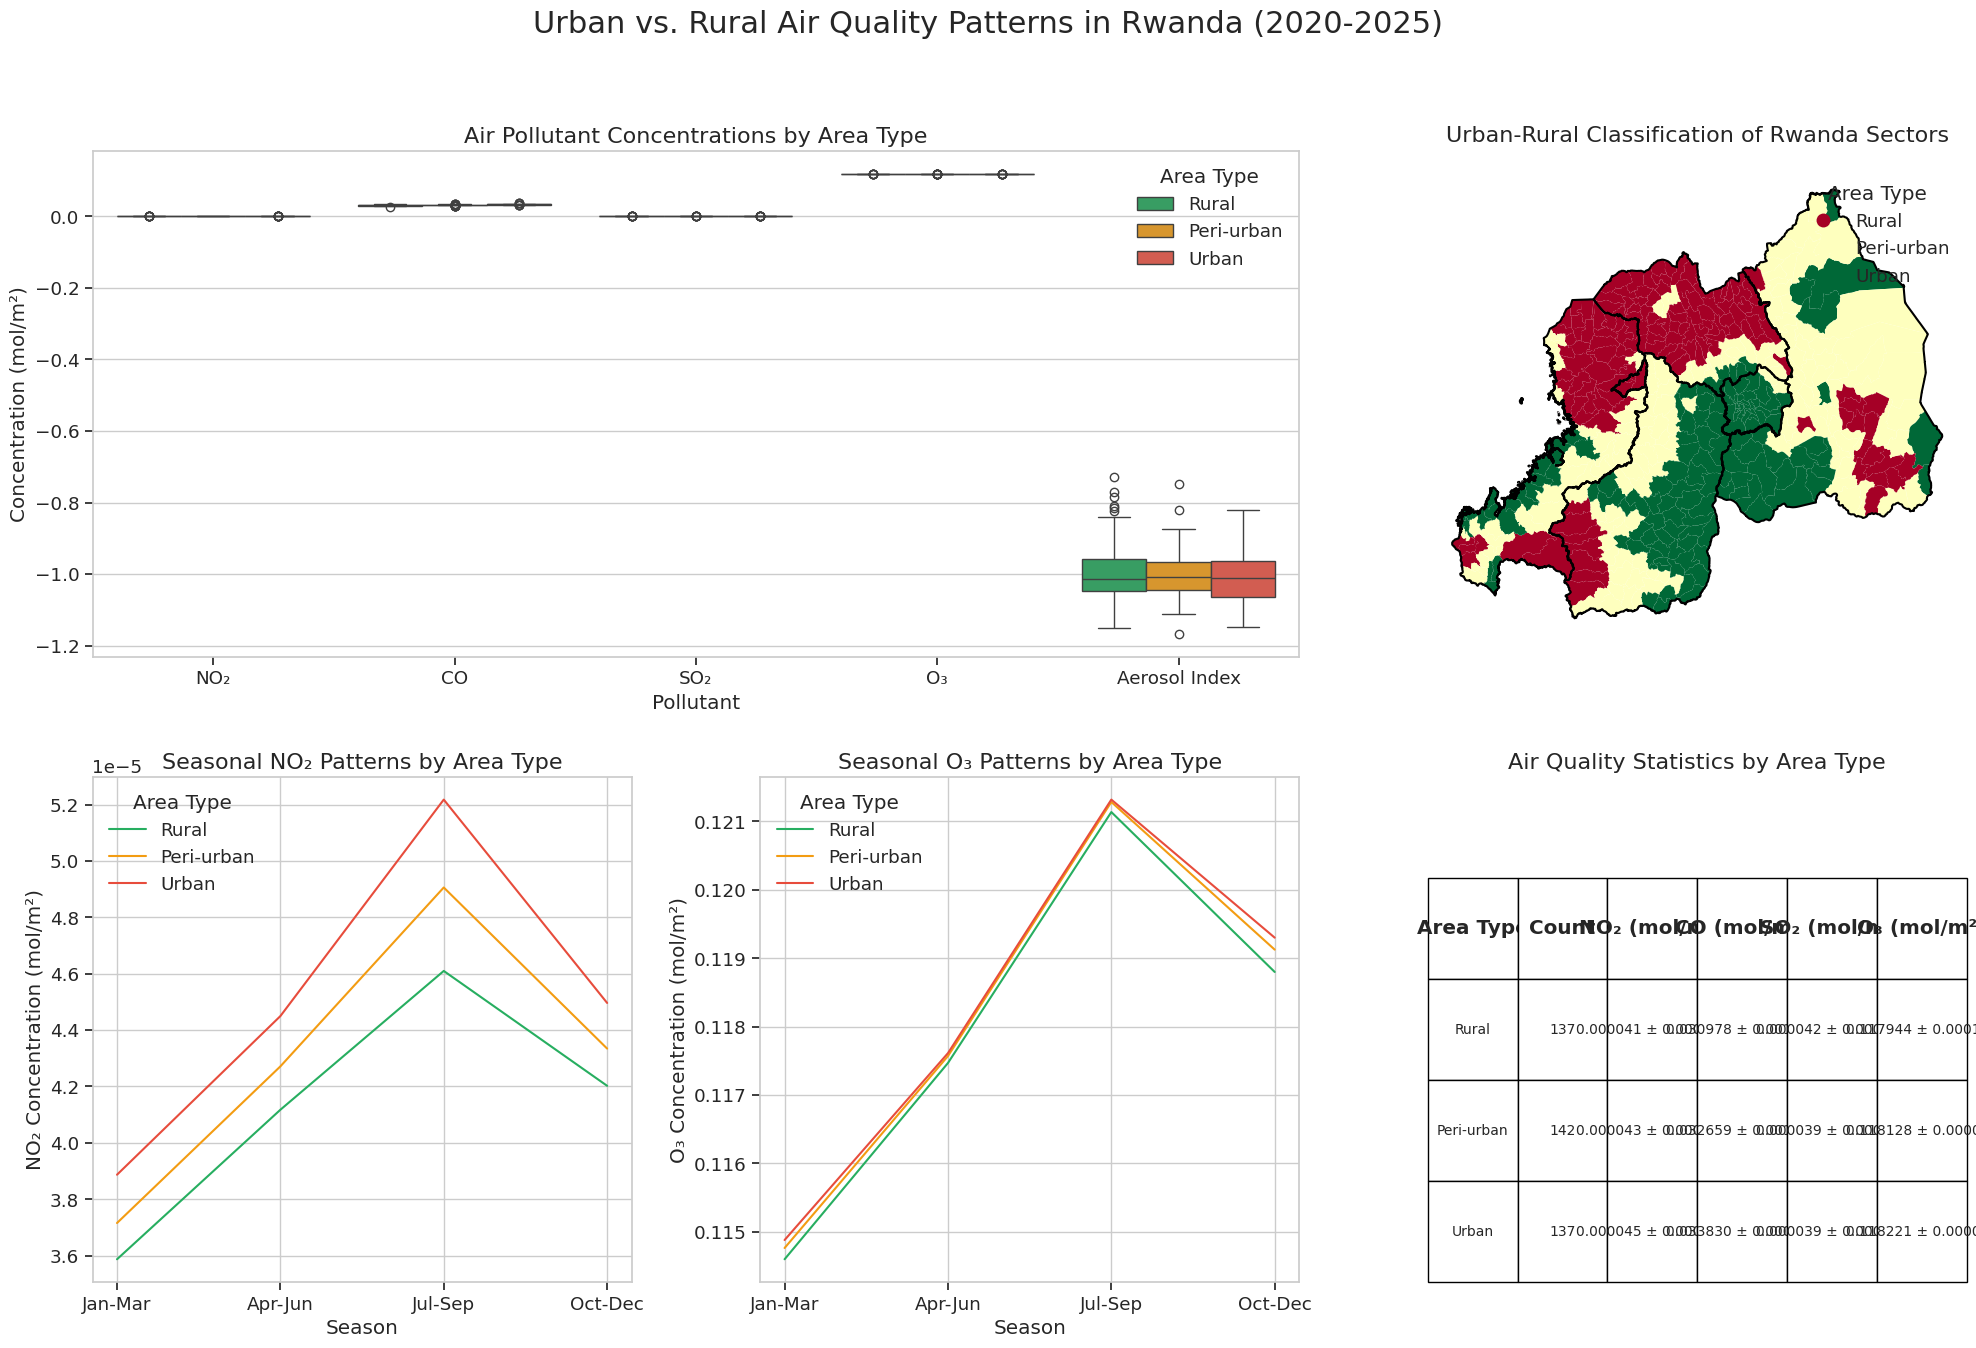

In [44]:
# 6. Urban-Rural Air Quality Analysis

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_context("notebook", font_scale=1.2)

# Create a classification for urban/rural
# Using NO2 as a proxy (higher in urban areas due to traffic)
sector_avg = df.groupby(['Sect_ID', 'District', 'Province']).agg({
    'NO2_mean': 'mean',
    'CO_mean': 'mean',
    'SO2_mean': 'mean',
    'O3_mean': 'mean',
    'AER_mean': 'mean'
}).reset_index()

# Classify sectors as urban, peri-urban or rural based on NO2 levels
sector_avg['urbanization'] = pd.qcut(
    sector_avg['NO2_mean'],
    [0, 0.33, 0.67, 1],
    labels=['Rural', 'Peri-urban', 'Urban']
)

# Create a figure for urban-rural comparison
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Urban vs. Rural Air Quality Patterns in Rwanda (2020-2025)',
             fontsize=22, y=0.98)

# 1. Boxplots comparing pollutant levels by urbanization category
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)

# Melt data for faceted boxplot
melted = pd.melt(
    sector_avg,
    id_vars=['urbanization', 'District', 'Province', 'Sect_ID'],
    value_vars=['NO2_mean', 'CO_mean', 'SO2_mean', 'O3_mean', 'AER_mean'],
    var_name='pollutant',
    value_name='concentration'
)

# Create prettier labels for the pollutants
melted['pollutant_label'] = melted['pollutant'].replace({
    'NO2_mean': 'NO₂',
    'CO_mean': 'CO',
    'SO2_mean': 'SO₂',
    'O3_mean': 'O₃',
    'AER_mean': 'Aerosol Index'
})

# Create faceted boxplot
sns.boxplot(
    x='pollutant_label',
    y='concentration',
    hue='urbanization',
    data=melted,
    palette={'Urban': '#E74C3C', 'Peri-urban': '#F39C12', 'Rural': '#27AE60'},
    ax=ax1
)

ax1.set_title('Air Pollutant Concentrations by Area Type', fontsize=16)
ax1.set_xlabel('Pollutant')
ax1.set_ylabel('Concentration (mol/m²)')
ax1.legend(title='Area Type')

# 2. Mapping urban/rural classification
ax2 = plt.subplot2grid((2, 3), (0, 2))

# Merge with GeoDataFrame for mapping
sector_geo = sectors_gdf.merge(
    sector_avg[['Sect_ID', 'urbanization']], on='Sect_ID')

# Create a map of urban/rural areas
sector_geo.plot(
    column='urbanization',
    categorical=True,
    cmap='RdYlGn',
    legend=True,
    ax=ax2,
    legend_kwds={'title': 'Area Type'}
)

# Add province boundaries
try:
    province_boundaries = sector_geo.dissolve(by='Province_x')
    province_boundaries.boundary.plot(ax=ax2, color='black', linewidth=1.5)
except:
    province_boundaries = sector_geo.dissolve(by='Province')
    province_boundaries.boundary.plot(ax=ax2, color='black', linewidth=1.5)

ax2.set_title('Urban-Rural Classification of Rwanda Sectors', fontsize=16)
ax2.set_axis_off()

# 3. Seasonal patterns by urbanization
ax3 = plt.subplot2grid((2, 3), (1, 0))

# Add season to the data
df['month'] = pd.to_datetime(df['date']).dt.month
df['season'] = pd.cut(
    df['month'],
    bins=[0, 3, 6, 9, 12],
    labels=['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'],
    include_lowest=True
)

# Merge urbanization classification with raw data
df_with_urban = df.merge(sector_avg[['Sect_ID', 'urbanization']], on='Sect_ID')

# Calculate NO2 seasonal patterns by urban/rural
seasonal_no2 = df_with_urban.groupby(['urbanization', 'season'])[
    'NO2_mean'].mean().reset_index()

# Create line plot
sns.lineplot(
    x='season',
    y='NO2_mean',
    hue='urbanization',
    data=seasonal_no2,
    palette={'Urban': '#E74C3C', 'Peri-urban': '#F39C12', 'Rural': '#27AE60'},
    markers=True,
    dashes=False,
    ax=ax3
)

ax3.set_title('Seasonal NO₂ Patterns by Area Type', fontsize=16)
ax3.set_xlabel('Season')
ax3.set_ylabel('NO₂ Concentration (mol/m²)')
ax3.legend(title='Area Type')

# 4. O3 seasonal patterns
ax4 = plt.subplot2grid((2, 3), (1, 1))

# Calculate O3 seasonal patterns by urban/rural
seasonal_o3 = df_with_urban.groupby(['urbanization', 'season'])[
    'O3_mean'].mean().reset_index()

# Create line plot
sns.lineplot(
    x='season',
    y='O3_mean',
    hue='urbanization',
    data=seasonal_o3,
    palette={'Urban': '#E74C3C', 'Peri-urban': '#F39C12', 'Rural': '#27AE60'},
    markers=True,
    dashes=False,
    ax=ax4
)

ax4.set_title('Seasonal O₃ Patterns by Area Type', fontsize=16)
ax4.set_xlabel('Season')
ax4.set_ylabel('O₃ Concentration (mol/m²)')
ax4.legend(title='Area Type')

# 5. Statistical comparison table
ax5 = plt.subplot2grid((2, 3), (1, 2))
ax5.axis('off')

# Calculate summary statistics by urban/rural classification
urban_stats = sector_avg.groupby('urbanization').agg({
    'NO2_mean': ['mean', 'std'],
    'CO_mean': ['mean', 'std'],
    'SO2_mean': ['mean', 'std'],
    'O3_mean': ['mean', 'std'],
    'AER_mean': ['mean', 'std'],
    'Sect_ID': 'count'
}).reset_index()

# Rename columns for readability
urban_stats.columns = ['_'.join(col).strip() if col[1] else col[0]
                       for col in urban_stats.columns.values]
urban_stats = urban_stats.rename(columns={
    'Sect_ID_count': 'Number of Sectors',
    'NO2_mean_mean': 'NO₂ Mean',
    'NO2_mean_std': 'NO₂ Std Dev',
    'CO_mean_mean': 'CO Mean',
    'CO_mean_std': 'CO Std Dev',
    'SO2_mean_mean': 'SO₂ Mean',
    'SO2_mean_std': 'SO₂ Std Dev',
    'O3_mean_mean': 'O₃ Mean',
    'O3_mean_std': 'O₃ Std Dev',
    'AER_mean_mean': 'Aerosol Mean',
    'AER_mean_std': 'Aerosol Std Dev'
})

# Create a table
table_data = []
for idx, row in urban_stats.iterrows():
    table_data.append([
        row['urbanization'],
        row['Number of Sectors'],
        f"{row['NO₂ Mean']:.6f} ± {row['NO₂ Std Dev']:.6f}",
        f"{row['CO Mean']:.6f} ± {row['CO Std Dev']:.6f}",
        f"{row['SO₂ Mean']:.6f} ± {row['SO₂ Std Dev']:.6f}",
        f"{row['O₃ Mean']:.6f} ± {row['O₃ Std Dev']:.6f}"
    ])

table = ax5.table(
    cellText=table_data,
    colLabels=['Area Type', 'Count',
               'NO₂ (mol/m²)', 'CO (mol/m²)', 'SO₂ (mol/m²)', 'O₃ (mol/m²)'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 0.8]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header
        cell.set_text_props(fontproperties=fm.FontProperties(weight='bold'))

ax5.set_title('Air Quality Statistics by Area Type', fontsize=16)


plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('rwanda_urban_rural_air_quality.png', dpi=300, bbox_inches='tight')
plt.show()